In [60]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print(f"GPU Detected: {gpu.device_type} - {gpu.name}")
else:
    print("No GPU detected")

No GPU detected


## Data acquisition

In [38]:
# Read data form csv
df = pd.read_csv("./FERPlus-master/fer2013new.csv")
df

,Usage,Image name,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,Training,fer0000000.png,4,0,0,1,3,2,0,0,0,0
1,Training,fer0000001.png,6,0,1,1,0,0,0,0,2,0
2,Training,fer0000002.png,5,0,0,3,1,0,0,0,1,0
3,Training,fer0000003.png,4,0,0,4,1,0,0,0,1,0
4,Training,fer0000004.png,9,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
35882,PrivateTest,fer0035797.png,8,0,0,2,0,0,0,0,0,0
35883,PrivateTest,NaN,0,0,0,0,0,0,0,0,0,10
35884,PrivateTest,fer0035799.png,0,0,0,0,7,1,0,2,0,0
35885,PrivateTest,fer0035800.png,0,10,0,0,0,0,0,0,0,0


In [39]:
# Display its general information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Usage       35887 non-null  object
 1   Image name  35714 non-null  object
 2   neutral     35887 non-null  int64 
 3   happiness   35887 non-null  int64 
 4   surprise    35887 non-null  int64 
 5   sadness     35887 non-null  int64 
 6   anger       35887 non-null  int64 
 7   disgust     35887 non-null  int64 
 8   fear        35887 non-null  int64 
 9   contempt    35887 non-null  int64 
 10  unknown     35887 non-null  int64 
 11  NF          35887 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 3.3+ MB


# Preprocessing

In [40]:
# Check for any missing data particularly in 'Image name' column
missing_data = df.isnull().sum()
missing_data

Usage           0
Image name    173
neutral         0
happiness       0
surprise        0
sadness         0
anger           0
disgust         0
fear            0
contempt        0
unknown         0
NF              0
dtype: int64

In [41]:
# Remove entries with missing 'Image name'
clean_df = df.dropna(subset=['Image name'])

# Confirm the removal
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35714 entries, 0 to 35886
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Usage       35714 non-null  object
 1   Image name  35714 non-null  object
 2   neutral     35714 non-null  int64 
 3   happiness   35714 non-null  int64 
 4   surprise    35714 non-null  int64 
 5   sadness     35714 non-null  int64 
 6   anger       35714 non-null  int64 
 7   disgust     35714 non-null  int64 
 8   fear        35714 non-null  int64 
 9   contempt    35714 non-null  int64 
 10  unknown     35714 non-null  int64 
 11  NF          35714 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 3.5+ MB


In [42]:
# Count of row types
print(clean_df['Usage'].value_counts())

Usage
Training       28561
PublicTest      3579
PrivateTest     3574
Name: count, dtype: int64


## Normalization

In [43]:
# Load and normalize images
def load_images(data, base_path):
    images = []
    labels = []
    paths = []
    
    # Mapping from Usage to directory names
    directory_map = {
        "Training": "FER2013Train",
        "PublicTest": "FER2013Valid",
        "PrivateTest": "FER2013Test"
    }
    
    for idx, row in data.iterrows():
        directory = directory_map.get(row['Usage'], None)
        if directory:
            image_path = os.path.join(base_path, directory, row['Image name'])
            
            if os.path.exists(image_path):
                # Load the image
                image = Image.open(image_path).convert('L')  # Convert to grayscale
                image_array = np.array(image) / 255.0  # Normalize to 0-1
                
                # Append data
                images.append(image_array)
                labels.append(row[2:12].values)  # Select emotion intensity columns
                paths.append(image_path)
    
    return np.array(images), np.array(labels), paths

# Base path for images
base_image_path = 'FERPLUS-master/data'

# Load images and their labels
images, labels, image_paths = load_images(clean_df, base_image_path)

# Check shapes and an example path
images.shape, labels.shape, image_paths[:5]

((35714, 48, 48),
 (35714, 10),
 ['FERPLUS-master/data\\FER2013Train\\fer0000000.png',
  'FERPLUS-master/data\\FER2013Train\\fer0000001.png',
  'FERPLUS-master/data\\FER2013Train\\fer0000002.png',
  'FERPLUS-master/data\\FER2013Train\\fer0000003.png',
  'FERPLUS-master/data\\FER2013Train\\fer0000004.png'])

## Splitting data

In [44]:
# Split data into differente usage
train_indices = [i for i, path in enumerate(image_paths) if 'FER2013Train' in path]
test_indices = [i for i, path in enumerate(image_paths) if 'FER2013Test' in path]
valid_indices = [i for i, path in enumerate(image_paths) if 'FER2013Valid' in path]

train_images = images[train_indices]
train_labels = labels[train_indices]
print("Train images info: ")
print(train_images.shape, train_labels.shape)

valid_images = images[valid_indices]
valid_labels = labels[valid_indices]
print("Valid images info: ")
print(valid_images.shape, valid_labels.shape)

test_images = images[test_indices]
test_labels = labels[test_indices]
print("Test images info: ")
print(test_images.shape, test_labels.shape)

Train images info: 
(28561, 48, 48) (28561, 10)
Valid images info: 
(3579, 48, 48) (3579, 10)
Test images info: 
(3574, 48, 48) (3574, 10)


## One hot encoding for labels

In [45]:
# One hot encode the labels
#train_labels = to_categorical(train_labels)
#test_labels = to_categorical(test_labels)
#valid_labels = to_categorical(valid_labels)

IndentationError: unexpected indent (1270747917.py, line 2)

# Basic CNN

In [46]:
# Create a basic CNN model
basic_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),  # first conv layer
    MaxPooling2D((2, 2)),  # first pooling layer
    Conv2D(64, (3, 3), activation='relu'),  # second conv layer
    MaxPooling2D((2, 2)),  # second pooling layer
    Conv2D(128, (3, 3), activation='relu'),  # third conv layer
    MaxPooling2D((2, 2)),  # third pooling layer
    Flatten(),  # flatten the output for the dense layer
    Dense(128, activation='relu'),  # fully connected layer
    Dropout(0.5),  # dropout for regularization
    Dense(10, activation='linear')  # output layer with 10 units for each emotion
])

basic_model.summary()  # This will print the summary of the model architecture

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 4, 4, 128)       

In [47]:
# Compile the model
basic_model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_squared_error']
)

## Reshape images to add channel dimension for CNN

In [48]:
# Reshape or modify the data to add a channel dimension for CNNs, expect an input shape like (batch, height, width, channels)
# Channel dimension is 1 for grayscale images
train_images = train_images.reshape((-1, 48, 48, 1))
test_images = test_images.reshape((-1, 48, 48, 1))
valid_images = valid_images.reshape((-1, 48, 48, 1))

In [53]:
print("Train images shape:", train_images.shape, train_images.dtype)
print("Valid images shape:", valid_images.shape, valid_images.dtype)
print("Tests images shape:", test_images.shape, test_images.dtype)

print("Train labels shape:", train_labels.shape, train_labels.dtype)
print("Valid labels shape:", valid_labels.shape, valid_labels.dtype)
print("Tests labels shape:", test_labels.shape, test_labels.dtype)


Train images shape: (28561, 48, 48, 1) float64
Valid images shape: (3579, 48, 48, 1) float64
Tests images shape: (3574, 48, 48, 1) float64
Train labels shape: (28561, 10) float32
Valid labels shape: (3579, 10) float32
Tests labels shape: (3574, 10) float32


In [51]:
train_labels = np.array(train_labels, dtype='float32')
valid_labels = np.array(valid_labels, dtype='float32')
test_labels = np.array(test_labels, dtype='float32')

## Fit model

In [54]:
# Fit the model
basic_model_history = basic_model.fit(
    train_images, train_labels,
    epochs=30,
    batch_size=64,
    validation_data=(valid_images, valid_labels)
)

Epoch 1/30
447/447 [==============================] - 89s 199ms/step - loss: 4.3210 - mean_squared_error: 4.3210 - val_loss: 3.7261 - val_mean_squared_error: 3.7261
Epoch 2/30
447/447 [==============================] - 32s 70ms/step - loss: 3.2655 - mean_squared_error: 3.2655 - val_loss: 3.0554 - val_mean_squared_error: 3.0554
Epoch 3/30
447/447 [==============================] - 23s 52ms/step - loss: 2.8954 - mean_squared_error: 2.8954 - val_loss: 2.8132 - val_mean_squared_error: 2.8132
Epoch 4/30
447/447 [==============================] - 23s 52ms/step - loss: 2.6848 - mean_squared_error: 2.6848 - val_loss: 2.6728 - val_mean_squared_error: 2.6728
Epoch 5/30
447/447 [==============================] - 23s 52ms/step - loss: 2.5267 - mean_squared_error: 2.5267 - val_loss: 2.4869 - val_mean_squared_error: 2.4869
Epoch 6/30
447/447 [==============================] - 23s 52ms/step - loss: 2.3932 - mean_squared_error: 2.3932 - val_loss: 2.3404 - val_mean_squared_error: 2.3404
Epoch 7/30
447/

## Evaluate

In [55]:
# Evaluate the model
test_loss, test_mse = basic_model.evaluate(test_images, test_labels)
print('Test MSE:', test_mse)

112/112 [==============================] - 1s 7ms/step - loss: 1.9039 - mean_squared_error: 1.9039
Test MSE: 1.9038771390914917


## Plot 

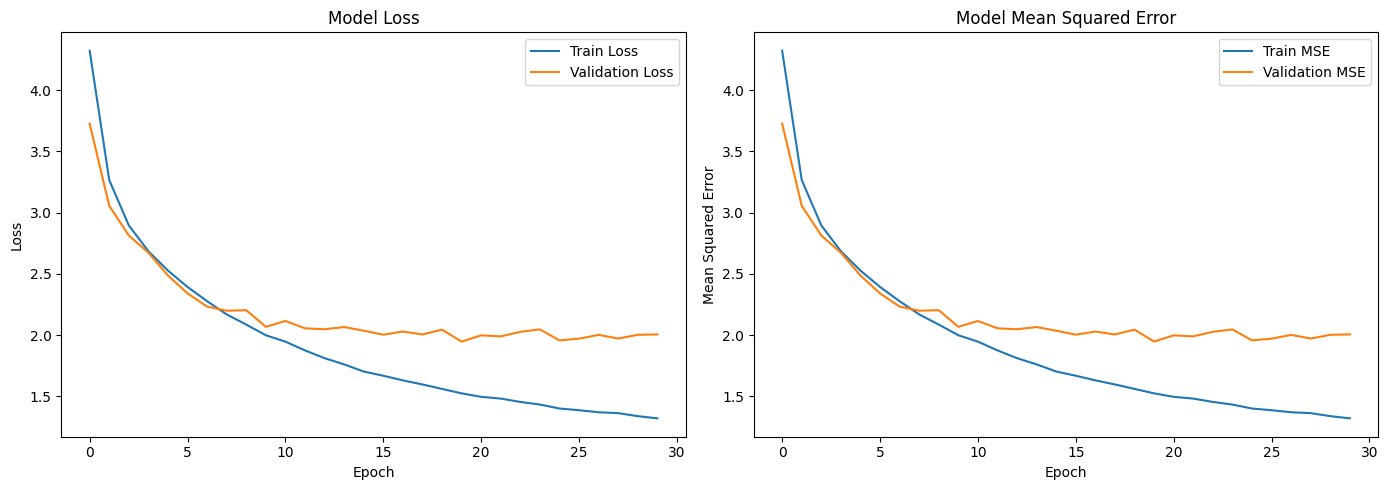

In [57]:
# Plot the history
# Assuming 'history' is the output from your model.fit()
plt.figure(figsize=(14, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(basic_model_history.history['loss'], label='Train Loss')
plt.plot(basic_model_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation mean squared error
plt.subplot(1, 2, 2)
plt.plot(basic_model_history.history['mean_squared_error'], label='Train MSE')
plt.plot(basic_model_history.history['val_mean_squared_error'], label='Validation MSE')
plt.title('Model Mean Squared Error')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Advanced CNN (VGG-like, ResNet)

# Transfer Learning (VGGFace, FaceNet)